# A Large Language Model From Scratch

Making your own Large Language Model (LLM) is a cool thing that many big companies like Google, Twitter, and Facebook are doing. They release different versions of these models, like 7 billion, 13 billion, or 70 billion. Even smaller communities are doing it too. You might have read blogs or watched videos on creating your own LLM, but they usually talk a lot about theory and not so much about the actual steps and code.

# Table of Contents
- Prerequisites
- Understanding the Transformer Architecture of LLaMA
    - Pre-normalization Using RMSNorm
    - SwiGLU Activation Function
    - Rotary Embeddings (RoPE)
- Setting the Stage
- Data Preprocessing
- Evaluation Strategy
- Setting Up a Base Neural Network Model
- Replicating LLaMA Architecture
    - RMSNorm for pre-normalization
    - Rotary Embeddings
    - SwiGLU activation function
- Experimenting with hyperparameters
- Conclusion

## Prerequisites

Make sure you have a basic understanding of object-oriented programming (**OOP**) and neural networks (**NN**). Familiarity with **PyTorch** will also be helpful in coding.

|Topic|Video Link|
|-----|----------|
|OOP  | [OOP Video](https://www.youtube.com/watch?v=Ej_02ICOIgs&pp=ygUKb29wIHB5dGhvbg%3D%3D)|
|Neural Network |[Neural Network Video](https://www.youtube.com/watch?v=Jy4wM2X21u0&pp=ygUbbmV1cmFsIG5ldHdvcmsgcHl0aG9uIHRvcmNo)|
|Pytorch |[Pytorch Video](https://www.youtube.com/watch?v=V_xro1bcAuA&pp=ygUbbmV1cmFsIG5ldHdvcmsgcHl0aG9uIHRvcmNo) |

## Understanding the Transformer Architecture of LLaMA

Before diving into creating our own LLM using the LLaMA approach, it’s essential to understand the architecture of LLaMA. Below is a comparison diagram between the vanilla transformer and LLaMA.



In case you’re not familiar with the vanilla transformer architecture, you can read [this blog](https://medium.com/@fareedkhandev/understanding-transformers-a-step-by-step-math-example-part-1-a7809015150a) for a basic guide.

Let’s look into the essential concepts of LLaMA with a bit more detail:

### Pre-normalization Using RMSNorm:

In the LLaMA approach, a technique called *RMSNorm* is employed for normalizing the input of each transformer sub-layer. This method is inspired by GPT-3 and is designed to optimize the computational cost associated with Layer Normalization. RMSNorm provides similar performance to LayerNorm but reduces the running time significantly (by 7%∼64%).

$$
\bar a_i = \frac{a_i}{RMS(a)}, \text{ where } RMS(a) = \sqrt{\frac{1}{n}\sum_{i=1}^n a_i^2}
$$

It achieves this by emphasizing re-scaling invariance and regulating the summed inputs based on the root mean square (RMS) statistic. The primary motivation is to simplify LayerNorm by removing the mean statistic. Interested readers can explore the detailed implementation of RMSNorm [here](https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py).

### SwiGLU Activation Function:

LLaMA introduces the SwiGLU activation function, drawing inspiration from PaLM. To understand SwiGLU, it’s essential to first grasp the Swish activation function. SwiGLU extends Swish and involves a custom layer with a dense network to split and multiply input activations.

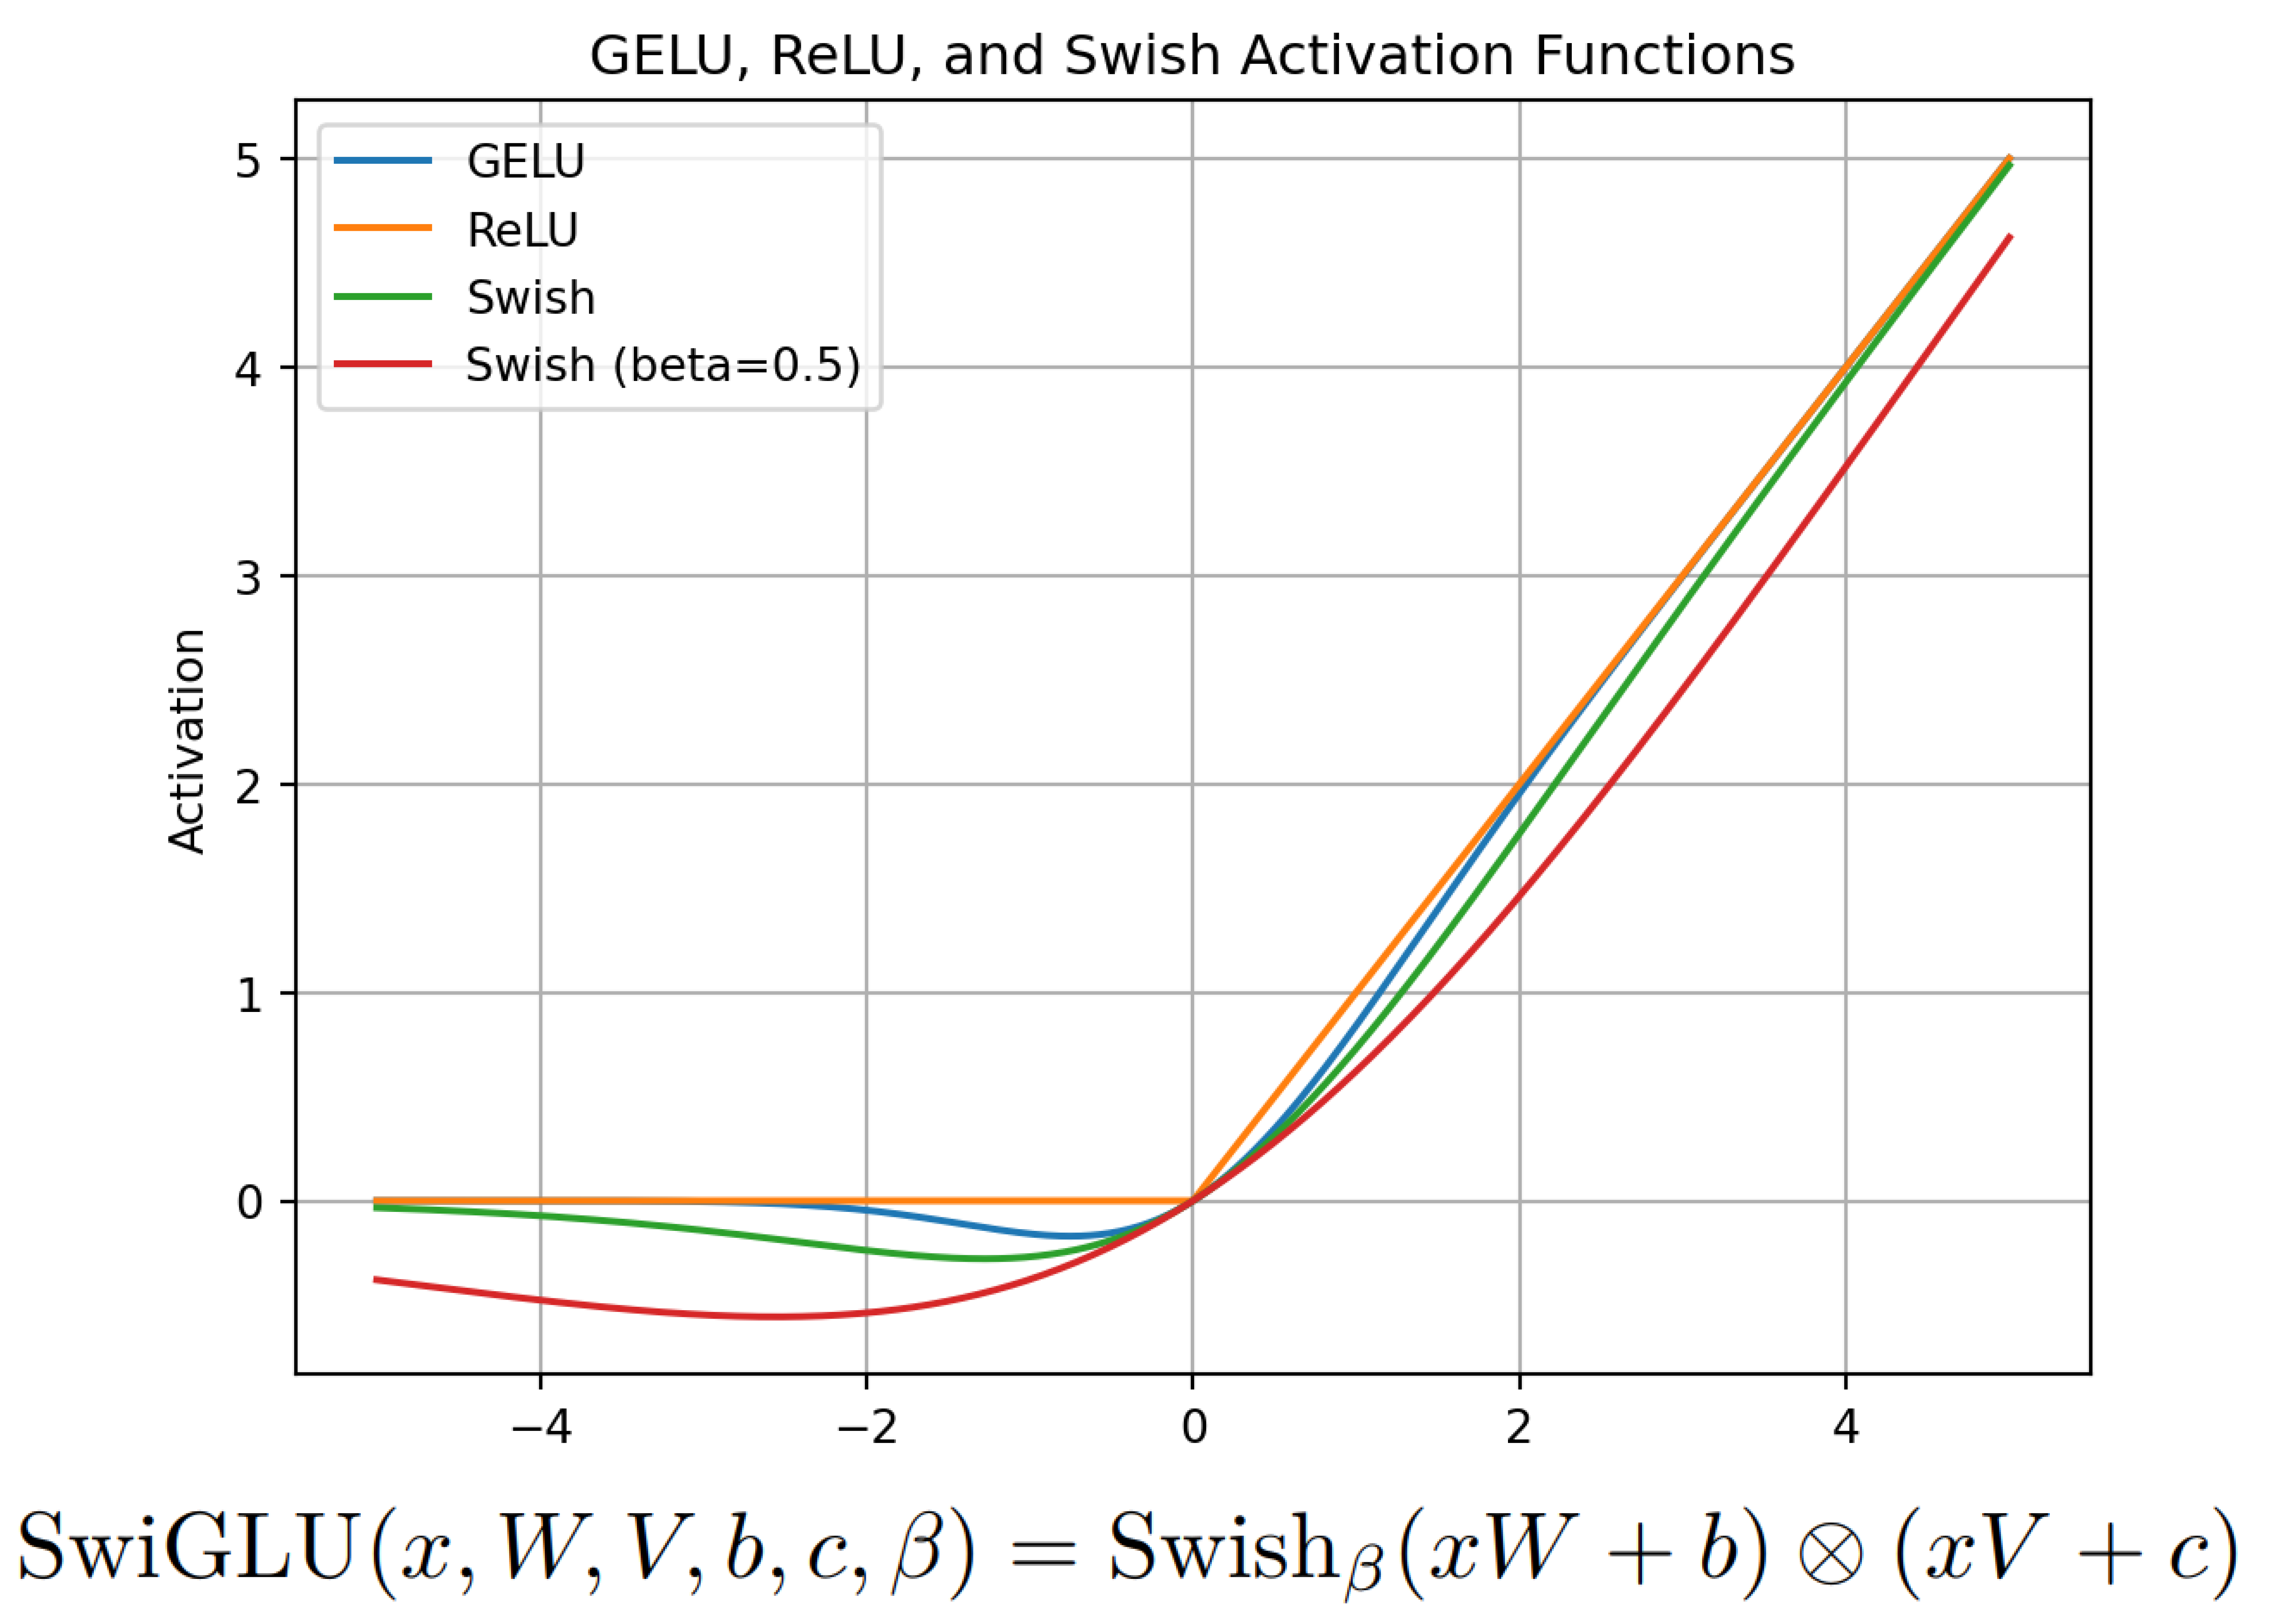

The aim is to enhance the expressive power of the model by introducing a more sophisticated activation function. Further details on SwiGLU can be found in the associated [paper](https://arxiv.org/pdf/2002.05202v1.pdf).

### Rotary Embeddings (RoPE):

Rotary Embeddings, or RoPE, is a type of position embedding used in LLaMA. It encodes absolute positional information using a rotation matrix and naturally includes explicit relative position dependency in self-attention formulations. RoPE offers advantages such as scalability to various sequence lengths and decaying inter-token dependency with increasing relative distances.

This is achieved by encoding relative positions through multiplication with a rotation matrix, resulting in decayed relative distances — a desirable feature for natural language encoding. Those interested in the mathematical details can refer to the [RoPE paper](https://arxiv.org/pdf/2104.09864v4.pdf).

In addition to these concepts, the LLaMA paper introduces other significant approaches, including the use of the **AdamW optimizer** with specific parameters, efficient implementations such as the causal [multi-head attention operator](https://facebookresearch.github.io/xformers/components/mha.html) available in the xformers library, and manually implemented backward functions for transformer layers to optimize computation during backward passes.

A special acknowledgment and thanks to [Anush Kumar](https://akgeni.medium.com/) for providing an in-depth explanation of each crucial aspect of LLaMA.


## Setting the Stage

We’ll be working with a range of Python libraries throughout this project, so let’s import them:

In [1]:
# PyTorch for implementing LLM (No GPU)
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import urllib.request
import lxml.etree as ETP
import os
import re
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from multiprocessing import Pool
import time
import random
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import RegexpTokenizer
import random
from nltk.stem.porter import *
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from multiprocessing import Pool, Manager
from datetime import datetime

Furthermore, we're creating a configuration object that stores model parameters.

In [2]:
# Configuration object for model parameters
MASTER_CONFIG = {
    # Adding parameters later
}

This approach maintains flexibility, allowing for the addition of more parameters as needed in the future.

## Data Preprocessing

In the original LLaMA paper, diverse open-source datasets were employed to train and evaluate the model. Unfortunately, utilizing extensive datasets may be impractical for smaller projects. Therefore, for our implementation, we’ll take a more modest approach by creating a dramatically scaled-down version of LLaMA.

Given the constraints of not having access to vast amounts of data, we will focus on training a simplified version of LLaMA using the **math stack exchange** dataset. This open source dataset, contains approximately 3,800,000 lines of text. This choice is influenced by [LLaMA: Open and Efficient Foundation Language Models](https://arxiv.org/pdf/2302.13971), which provides valuable insights into training language models.

First, let’s obtain our dataset [here](https://archive.org/download/stackexchange) and download it directly [math.stackexchange.com.7z](https://archive.org/download/stackexchange/math.stackexchange.com.7z):

## Data Cleaning

We include the dump of Math Stack Exchange, a website of high quality questions and answers that covers a diverse set of domains, ranging from undergrad to graduate level question. We removed the HTML tags from text and sorted the answers by score (from highest to lowest).

In [3]:
import xml.etree.ElementTree as ET
from io import StringIO

def parse_large_xml(xmlfile, start_count):
    # Create an empty list to store news items
    newsitems = []
    # Initialize the counter
    count = start_count
    # Use iterparse for streaming
    context = ET.iterparse(xmlfile, events=('start', 'end'))
    
    # Process each element
    for event, elem in context:
        if event == 'end' and elem.tag == 'row':
            news = {}
            for key, val in elem.items():
                news[key] = val
            
            # Add the news item to the list
            newsitems.append(news)
            
            # Increment the counter
            count += 1
            if count%500_000 == 0:
                print(f'finished row {count}')
    
    return newsitems

In [4]:
start_count = 0
newsitems = parse_large_xml("data/Posts.xml", start_count)

finished row 500000
finished row 1000000
finished row 1500000
finished row 2000000
finished row 2500000
finished row 3000000
finished row 3500000


In [5]:
len(newsitems)

3792435

In [ ]:
df = pd.DataFrame(newsitems)

  <row Id="9976274" PostId="1" Score="1" Text="Hi there! You have asked Question ID 1. I don't know if you have ever noticed it before. But just mentioning it out" CreationDate="2023-06-02T11:08:30.117" UserId="960957" />

  <row Id="1" PostTypeId="1" AcceptedAnswerId="9" CreationDate="2010-07-20T19:09:27.200" Score="197" ViewCount="12829" Body="&lt;p&gt;Can someone explain to me how there can be different kinds of infinities?&lt;/p&gt;&#xA;&#xA;&lt;p&gt;I was reading &quot;&lt;a href=&quot;http://en.wikipedia.org/wiki/The_Man_Who_Loved_Only_Numbers&quot; rel=&quot;noreferrer&quot;&gt;The man who loved only numbers&lt;/a&gt;&quot; by &lt;a href=&quot;http://en.wikipedia.org/wiki/Paul_Hoffman_(science_writer)&quot; rel=&quot;noreferrer&quot;&gt;Paul Hoffman&lt;/a&gt; and came across the concept of countable and uncountable infinities, but they're only words to me.&lt;/p&gt;&#xA;&#xA;&lt;p&gt;Any help would be appreciated.&lt;/p&gt;&#xA;" OwnerUserId="10" LastEditorUserId="32803" LastEditorDisplayName="user126" LastEditDate="2018-03-01T19:53:22.017" LastActivityDate="2023-05-17T06:11:58.107" Title="What Does it Really Mean to Have Different Kinds of Infinities?" Tags="|elementary-set-theory|intuition|infinity|faq|" AnswerCount="9" CommentCount="2" ContentLicense="CC BY-SA 3.0" />

  <row Id="1" PostHistoryTypeId="2" PostId="1" RevisionGUID="5a5f5a4e-059b-44c2-9da0-6462fbd42dea" CreationDate="2010-07-20T19:09:27.200" UserId="10" Text="Can someone explain to me how there can be different kinds of infinities?&#xD;&#xA;&#xD;&#xA;I was reading &quot;the man who loved only numbers&quot; and came across the concept of countable and uncountable infinities, but they're only words to me.&#xD;&#xA;&#xD;&#xA;Any help would be appreciated." ContentLicense="CC BY-SA 2.5" />